In [ ]:
import nltk
nltk.download('sentiwordnet')
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
import pandas as pd

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

In [ ]:
def calculate_sentiment(sentence):
    token = nltk.word_tokenize(sentence)
    after_tagging = nltk.pos_tag(token)
    sentiment = 0.0
    tokens_count = 0
    lemmatizer = WordNetLemmatizer()

    for word, tag in after_tagging:
        wn_tag = penn_to_wn(tag)
        if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
            continue

        lemma = lemmatizer.lemmatize(word, pos=wn_tag)
        if not lemma:
            continue

        synsets = wn.synsets(lemma, pos=wn_tag)
        if not synsets:
            continue

        # Take the first sense, the most common
        synset = synsets[0]
        swn_synset = swn.senti_synset(synset.name())
        sentiment += swn_synset.pos_score() - swn_synset.neg_score()
        tokens_count += 1

    if tokens_count != 0:
        sentiment /= tokens_count

    return sentiment

In [ ]:
data = pd.read_parquet('/content/train-00000-of-00001-ab3fbf4a5662c2a8.parquet')

In [ ]:
data.head()

,MeSH,Problems,findings,impression
0,Atherosclerosis/aorta;Arthritis,Atherosclerosis;Arthritis,The lungs are clear. There is no pleural effus...,No acute pulmonary disease.
1,Bullous Emphysema/lung/apex/bilateral;Thoracic...,Bullous Emphysema;Thoracic Vertebrae,Cardiomediastinal silhouette are normal in siz...,1. No acute cardiopulmonary abnormality. 2. St...
2,Breast Implants/bilateral,Breast Implants,The heart is normal in size. The mediastinum i...,No acute disease.
3,Calcified Granuloma/lung/middle lobe,Calcified Granuloma,The cardiomediastinal silhouette is normal in ...,Negative for acute abnormality.
4,Lung/hypoinflation;Markings/bronchovascular,Lung;Markings,There are lower lung volumes. There is central...,No acute abnormality identified.


In [ ]:
def senti_subject(column, data=data):
  sentiments = []
  sent_subj = [calculate_sentiment(txt) for txt in data[column]]
  for sent_subj_ in sent_subj:
    sentiments.append(sent_subj_)  # Append sent_subj_ instead of sent_subj
  return sentiments

senti_subj_columns = ['MeSH', 'Problems', 'findings', 'impression']
for col in senti_subj_columns:
  sents = senti_subject(col)
  data[f'{col} Sentiment'] = sents

In [ ]:
data.head()

,MeSH,Problems,findings,impression,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
0,Atherosclerosis/aorta;Arthritis,Atherosclerosis;Arthritis,The lungs are clear. There is no pleural effus...,No acute pulmonary disease.,-0.25,-0.125,-0.008333,-0.125000
1,Bullous Emphysema/lung/apex/bilateral;Thoracic...,Bullous Emphysema;Thoracic Vertebrae,Cardiomediastinal silhouette are normal in siz...,1. No acute cardiopulmonary abnormality. 2. St...,0.00,0.000,-0.046875,-0.020833
2,Breast Implants/bilateral,Breast Implants,The heart is normal in size. The mediastinum i...,No acute disease.,0.00,0.000,-0.050000,-0.187500
3,Calcified Granuloma/lung/middle lobe,Calcified Granuloma,The cardiomediastinal silhouette is normal in ...,Negative for acute abnormality.,0.00,-0.750,-0.125000,-0.375000
4,Lung/hypoinflation;Markings/bronchovascular,Lung;Markings,There are lower lung volumes. There is central...,No acute abnormality identified.,0.00,0.000,-0.029412,-0.125000


In [ ]:
string_sentiment = []

for index, v in data[['MeSH Sentiment', 'Problems Sentiment', 'findings Sentiment', 'impression Sentiment']].iterrows():
  avg_sent = sum([v['MeSH Sentiment'], v['Problems Sentiment'], v['findings Sentiment'], v['impression Sentiment']])

  if avg_sent < 0:
    string_sentiment.append('Negative')
  elif avg_sent > 0:
    string_sentiment.append('Positive')
  else:
    string_sentiment.append('Neutral')

data['Avg Sentiment'] = string_sentiment
data.head()

,MeSH,Problems,findings,impression,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment,Avg Sentiment
0,Atherosclerosis/aorta;Arthritis,Atherosclerosis;Arthritis,The lungs are clear. There is no pleural effus...,No acute pulmonary disease.,-0.25,-0.125,-0.008333,-0.125000,Negative
1,Bullous Emphysema/lung/apex/bilateral;Thoracic...,Bullous Emphysema;Thoracic Vertebrae,Cardiomediastinal silhouette are normal in siz...,1. No acute cardiopulmonary abnormality. 2. St...,0.00,0.000,-0.046875,-0.020833,Negative
2,Breast Implants/bilateral,Breast Implants,The heart is normal in size. The mediastinum i...,No acute disease.,0.00,0.000,-0.050000,-0.187500,Negative
3,Calcified Granuloma/lung/middle lobe,Calcified Granuloma,The cardiomediastinal silhouette is normal in ...,Negative for acute abnormality.,0.00,-0.750,-0.125000,-0.375000,Negative
4,Lung/hypoinflation;Markings/bronchovascular,Lung;Markings,There are lower lung volumes. There is central...,No acute abnormality identified.,0.00,0.000,-0.029412,-0.125000,Negative


In [ ]:
data.to_csv('Medical_Reports_Split_Sentiwordnet.csv', index=False)

In [ ]:
column_names = ['MeSH Sentiment', 'Problems Sentiment', 'findings Sentiment', 'impression Sentiment']
data_frames = {}

for column in column_names:
    neg_df = data[data[column] < 0.0].copy()
    pos_df = data[data[column] > 0.0].copy()
    neu_df = data[data[column] == 0.0].copy()

    # Create separate data frames
    data_frames[column + '_neg'] = neg_df.copy()
    data_frames[column + '_pos'] = pos_df.copy()
    data_frames[column + '_neu'] = neu_df.copy()

In [ ]:
for key in data_frames.keys():
    print(key)
    display(data_frames[key].describe())
    print()

MeSH Sentiment_neg


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,1258.000000,1258.000000,1258.000000,1258.000000
mean,-0.446158,-0.434606,-0.028715,-0.122246
std,0.129980,0.149258,0.055854,0.123297
min,-0.750000,-0.750000,-0.192308,-0.875000
25%,-0.500000,-0.500000,-0.059524,-0.166667
50%,-0.500000,-0.500000,-0.030364,-0.118750
75%,-0.500000,-0.500000,0.000000,-0.083333
max,-0.012500,0.250000,0.140625,0.250000



MeSH Sentiment_pos


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,210.000000,210.000000,210.000000,210.000000
mean,0.099742,0.008940,-0.040782,-0.077030
std,0.049139,0.098479,0.050514,0.122290
min,0.020833,-0.312500,-0.200000,-0.875000
25%,0.062500,-0.041667,-0.070312,-0.156250
50%,0.125000,0.041667,-0.034483,-0.083333
75%,0.125000,0.062500,-0.007468,-0.015625
max,0.312500,0.250000,0.079545,0.250000



MeSH Sentiment_neu


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,1363.0,1363.000000,1363.000000,1363.000000
mean,0.0,-0.104558,-0.042132,-0.078361
std,0.0,0.217811,0.049412,0.104065
min,0.0,-0.750000,-0.333333,-0.750000
25%,0.0,-0.166667,-0.073529,-0.125000
50%,0.0,0.000000,-0.041667,-0.083333
75%,0.0,0.000000,-0.010417,0.000000
max,0.0,0.333333,0.156250,0.375000



Problems Sentiment_neg


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,1811.000000,1811.000000,1811.000000,1811.000000
mean,-0.304762,-0.393854,-0.038540,-0.112705
std,0.238863,0.185579,0.056171,0.117140
min,-0.750000,-0.750000,-0.333333,-0.875000
25%,-0.500000,-0.500000,-0.070312,-0.166667
50%,-0.500000,-0.500000,-0.035714,-0.083333
75%,0.000000,-0.243750,-0.008073,-0.062500
max,0.166667,-0.011364,0.140625,0.375000



Problems Sentiment_pos


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,269.000000,269.000000,269.000000,269.000000
mean,0.042650,0.096285,-0.030802,-0.060151
std,0.081706,0.072892,0.045352,0.129173
min,-0.375000,0.015625,-0.151786,-0.875000
25%,0.000000,0.041667,-0.058333,-0.131944
50%,0.020833,0.062500,-0.027778,-0.062500
75%,0.125000,0.125000,0.000000,0.000000
max,0.312500,0.333333,0.079545,0.250000



Problems Sentiment_neu


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,751.000000,751.0,751.000000,751.000000
mean,0.000172,0.0,-0.032000,-0.075205
std,0.025577,0.0,0.046330,0.102414
min,-0.500000,0.0,-0.180556,-0.541667
25%,0.000000,0.0,-0.061343,-0.125000
50%,0.000000,0.0,-0.033333,-0.083333
75%,0.000000,0.0,0.000000,0.000000
max,0.250000,0.0,0.156250,0.375000



findings Sentiment_neg


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,2133.000000,2133.000000,2133.000000,2133.000000
mean,-0.179802,-0.244434,-0.057772,-0.094409
std,0.244045,0.252738,0.039531,0.103402
min,-0.750000,-0.750000,-0.333333,-0.750000
25%,-0.500000,-0.500000,-0.076923,-0.166667
50%,0.000000,-0.187500,-0.050000,-0.083333
75%,0.000000,0.000000,-0.027778,-0.031250
max,0.250000,0.333333,-0.003205,0.375000



findings Sentiment_pos


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,565.000000,565.000000,565.000000,565.000000
mean,-0.244042,-0.254766,0.037369,-0.106298
std,0.248257,0.249575,0.024782,0.156679
min,-0.625000,-0.750000,0.003788,-0.875000
25%,-0.500000,-0.500000,0.015625,-0.125000
50%,-0.250000,-0.250000,0.031250,-0.083333
75%,0.000000,0.000000,0.053571,-0.041667
max,0.312500,0.333333,0.156250,0.375000



findings Sentiment_neu


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,133.000000,133.000000,133.0,133.000000
mean,-0.142262,-0.165775,0.0,-0.115304
std,0.233690,0.247616,0.0,0.109936
min,-0.500000,-0.750000,0.0,-0.312500
25%,-0.500000,-0.500000,0.0,-0.166667
50%,0.000000,0.000000,0.0,-0.125000
75%,0.000000,0.000000,0.0,-0.075000
max,0.166667,0.250000,0.0,0.250000



impression Sentiment_neg


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,2241.000000,2241.000000,2241.000000,2241.000000
mean,-0.207269,-0.265493,-0.036683,-0.134712
std,0.247753,0.248711,0.053684,0.096335
min,-0.750000,-0.750000,-0.333333,-0.875000
25%,-0.500000,-0.500000,-0.069444,-0.166667
50%,0.000000,-0.250000,-0.035714,-0.125000
75%,0.000000,0.000000,-0.004464,-0.083333
max,0.312500,0.333333,0.156250,-0.005435



impression Sentiment_pos


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,296.000000,296.000000,296.000000,296.000000
mean,-0.083439,-0.104744,-0.040555,0.084868
std,0.198023,0.217514,0.048856,0.078365
min,-0.750000,-0.750000,-0.192308,0.004167
25%,0.000000,-0.171875,-0.071429,0.031250
50%,0.000000,0.000000,-0.037500,0.053571
75%,0.000000,0.000000,-0.007595,0.107701
max,0.208333,0.250000,0.102273,0.375000



impression Sentiment_neu


,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment
count,294.000000,294.000000,294.000000,294.0
mean,-0.173925,-0.208830,-0.026883,0.0
std,0.247541,0.265356,0.049282,0.0
min,-0.750000,-0.750000,-0.194444,0.0
25%,-0.500000,-0.500000,-0.042256,0.0
50%,0.000000,-0.062500,-0.021739,0.0
75%,0.000000,0.000000,-0.001359,0.0
max,0.250000,0.300000,0.087500,0.0


Hypothesis Testing

In [ ]:
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu

In [ ]:
#Hypothesis 3: Difference in sentiment scores between different medical specialties
medical_specialties = data['MeSH'].unique()
groups = [data[data['MeSH'] == specialty]['Problems Sentiment'] for specialty in medical_specialties]
f_value, p_value = f_oneway(*groups)
if p_value < 0.05:
  print("Hypothesis 2: Reject the null hypothesis")
else:
  print("Hypothesis 2: Fail to reject the null hypothesis")

Hypothesis 2: Reject the null hypothesis


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [ ]:
#Hypothesis 3: Difference in sentiment scores between different medical specialties
medical_specialties = data['MeSH'].unique()
groups = [data[data['MeSH'] == specialty]['findings Sentiment'] for specialty in medical_specialties]
f_value, p_value = f_oneway(*groups)
if p_value < 0.05:
  print("Hypothesis 2: Reject the null hypothesis")
else:
  print("Hypothesis 2: Fail to reject the null hypothesis")

Hypothesis 2: Fail to reject the null hypothesis


In [ ]:
#Hypothesis 3: Difference in sentiment scores between different medical specialties
medical_specialties = data['MeSH'].unique()
groups = [data[data['MeSH'] == specialty]['impression Sentiment'] for specialty in medical_specialties]
f_value, p_value = f_oneway(*groups)
if p_value < 0.05:
  print("Hypothesis 2: Reject the null hypothesis")
else:
  print("Hypothesis 2: Fail to reject the null hypothesis")

Hypothesis 2: Fail to reject the null hypothesis


Null hypothesis (H0): There is no significant difference in sentiment scores between the MeSH, Problems, Findings, and Impression columns.
Alternative hypothesis (H1): There is a significant difference in sentiment scores between the MeSH, Problems, Findings, and Impression columns.

In [ ]:
f_statistic, p_value = f_oneway(
    data['MeSH Sentiment'],
    data['Problems Sentiment'],
    data['findings Sentiment'],
    data['impression Sentiment']
)

if p_value < 0.05:
    print("Hypothesis: Reject the null hypothesis")
else:
    print("Hypothesis: Fail to reject the null hypothesis")

Hypothesis: Reject the null hypothesis


In [ ]:
data1 =  pd.read_csv('/content/mtsamples.csv')

In [ ]:
data1.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3931 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


In [ ]:
data1.isnull().sum()

description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1068
dtype: int64

In [ ]:
df = data1.dropna()

In [ ]:
df.isnull().sum()

description          0
medical_specialty    0
sample_name          0
transcription        0
keywords             0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3898 entries, 0 to 4995
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        3898 non-null   object
 1   medical_specialty  3898 non-null   object
 2   sample_name        3898 non-null   object
 3   transcription      3898 non-null   object
 4   keywords           3898 non-null   object
dtypes: object(5)
memory usage: 182.7+ KB


In [ ]:
df.head()

,description,medical_specialty,sample_name,transcription,keywords
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
len(df.index)

3898

In [ ]:
def senti_subject_1(column, data=df):
  sentiments = []
  sent_subj = [calculate_sentiment(txt) for txt in data[column]]
  for sent_subj_ in sent_subj:
    sentiments.append(sent_subj_)
  return sentiments

senti_subj_columns = ['description','medical_specialty','sample_name','transcription']
for col in senti_subj_columns:
  sents = senti_subject_1(col)
  df[f'{col} Sentiment'] = sents

<ipython-input-17-8cebb4bb6216>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col} Sentiment'] = sents
<ipython-input-17-8cebb4bb6216>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col} Sentiment'] = sents
<ipython-input-17-8cebb4bb6216>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [ ]:
df.head()

,description,medical_specialty,sample_name,transcription,keywords,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",-0.125,-0.0625,-0.5,-0.044014
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...",0.000,0.0000,0.0,-0.081461
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",0.000,0.0000,0.0,-0.040984
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",0.000,0.0000,0.0,-0.009868
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",0.000,0.0000,0.0,-0.011364


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3898 entries, 0 to 4995
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   description                  3898 non-null   object 
 1   medical_specialty            3898 non-null   object 
 2   sample_name                  3898 non-null   object 
 3   transcription                3898 non-null   object 
 4   keywords                     3898 non-null   object 
 5   description Sentiment        3898 non-null   float64
 6   medical_specialty Sentiment  3898 non-null   float64
 7   sample_name Sentiment        3898 non-null   float64
 8   transcription Sentiment      3898 non-null   float64
dtypes: float64(4), object(5)
memory usage: 304.5+ KB


In [ ]:
string_sentiment = []

for index, v in df[['description Sentiment', 'medical_specialty Sentiment', 'sample_name Sentiment', 'transcription Sentiment']].iterrows():
  avg_sent = sum([v['description Sentiment'], v['medical_specialty Sentiment'], v['sample_name Sentiment'], v['transcription Sentiment']])

  if avg_sent < 0:
    string_sentiment.append('Negative')
  elif avg_sent > 0:
    string_sentiment.append('Positive')
  else:
    string_sentiment.append('Neutral')

df['Avg Sentiment'] = string_sentiment
df.head()

<ipython-input-20-a25b77a5918f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Avg Sentiment'] = string_sentiment


,description,medical_specialty,sample_name,transcription,keywords,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment,Avg Sentiment
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",-0.125,-0.0625,-0.5,-0.044014,Negative
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...",0.000,0.0000,0.0,-0.081461,Negative
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",0.000,0.0000,0.0,-0.040984,Negative
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",0.000,0.0000,0.0,-0.009868,Negative
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",0.000,0.0000,0.0,-0.011364,Negative


In [ ]:
df.to_csv('Medical_Transcriptions_Sentiwordnet.csv', index=False)

In [ ]:
column_names = ['description Sentiment','medical_specialty Sentiment','sample_name Sentiment','transcription Sentiment']
data_frames_1 = {}

for column in column_names:
    neg_df = df[df[column] < 0.0].copy()
    pos_df = df[df[column] > 0.0].copy()
    neu_df = df[df[column] == 0.0].copy()

    # Create separate data frames
    data_frames_1[column + '_neg'] = neg_df.copy()
    data_frames_1[column + '_pos'] = pos_df.copy()
    data_frames_1[column + '_neu'] = neu_df.copy()

In [ ]:
for key in data_frames_1.keys():
    print(key)
    display(data_frames_1[key].describe())
    print()

description Sentiment_neg


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,2079.000000,2079.000000,2079.000000,2079.000000
mean,-0.090551,-0.006684,-0.053317,-0.021527
std,0.079980,0.047162,0.139281,0.036400
min,-0.625000,-0.375000,-0.750000,-0.350926
25%,-0.125000,0.000000,-0.041667,-0.037185
50%,-0.069444,0.000000,0.000000,-0.017544
75%,-0.034091,0.000000,0.000000,-0.001078
max,-0.005000,0.125000,0.250000,0.187500



description Sentiment_pos


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,1004.000000,1004.000000,1004.000000,1004.000000
mean,0.050233,-0.003652,0.007128,-0.002490
std,0.045989,0.038126,0.078318,0.024667
min,0.004167,-0.375000,-0.750000,-0.101293
25%,0.020833,0.000000,0.000000,-0.016827
50%,0.035714,0.000000,0.000000,0.000000
75%,0.062500,0.000000,0.000000,0.015035
max,0.375000,0.125000,0.375000,0.064189



description Sentiment_neu


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,815.0,815.000000,815.000000,815.000000
mean,0.0,-0.009918,0.000624,-0.009558
std,0.0,0.064718,0.043907,0.024233
min,0.0,-0.375000,-0.375000,-0.099537
25%,0.0,0.000000,0.000000,-0.022020
50%,0.0,0.000000,0.000000,-0.006757
75%,0.0,0.000000,0.000000,0.006443
max,0.0,0.125000,0.375000,0.083333



medical_specialty Sentiment_neg


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,107.000000,107.000000,107.000000,107.000000
mean,-0.034584,-0.268886,-0.024319,-0.020767
std,0.081230,0.120888,0.099828,0.028660
min,-0.272727,-0.375000,-0.500000,-0.083333
25%,-0.073214,-0.375000,0.000000,-0.039419
50%,-0.011364,-0.375000,0.000000,-0.018519
75%,0.000000,-0.166667,0.000000,0.000000
max,0.208333,-0.062500,0.250000,0.042683



medical_specialty Sentiment_pos


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,25.000000,25.000,25.000000,25.000000
mean,-0.003456,0.125,-0.001667,0.001263
std,0.052189,0.000,0.008333,0.011440
min,-0.145833,0.125,-0.041667,-0.027955
25%,-0.011364,0.125,0.000000,-0.006455
50%,0.000000,0.125,0.000000,0.001820
75%,0.020833,0.125,0.000000,0.006443
max,0.093750,0.125,0.000000,0.022727



medical_specialty Sentiment_neu


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,3766.000000,3766.0,3766.000000,3766.000000
mean,-0.035591,0.0,-0.026696,-0.014035
std,0.088263,0.0,0.115457,0.032626
min,-0.625000,0.0,-0.750000,-0.350926
25%,-0.075000,0.0,0.000000,-0.029356
50%,-0.012500,0.0,0.000000,-0.009875
75%,0.007698,0.0,0.000000,0.005682
max,0.375000,0.0,0.375000,0.187500



sample_name Sentiment_neg


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,720.000000,720.000000,720.000000,720.000000
mean,-0.085659,-0.005584,-0.193471,-0.022940
std,0.098860,0.038702,0.171903,0.034492
min,-0.625000,-0.375000,-0.750000,-0.246063
25%,-0.125000,0.000000,-0.250000,-0.039812
50%,-0.075000,0.000000,-0.125000,-0.020164
75%,-0.020833,0.000000,-0.062500,-0.002350
max,0.187500,0.125000,-0.017857,0.187500



sample_name Sentiment_pos


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,346.000000,346.000000,346.000000,346.000000
mean,-0.018404,-0.005539,0.104383,-0.025677
std,0.099806,0.039201,0.076652,0.058862
min,-0.368056,-0.375000,0.025000,-0.350926
25%,-0.075000,0.000000,0.041667,-0.040450
50%,0.000000,0.000000,0.062500,-0.015873
75%,0.041667,0.000000,0.125000,0.006699
max,0.208333,0.000000,0.375000,0.051724



sample_name Sentiment_neu


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,2832.000000,2832.000000,2832.0,2832.000000
mean,-0.024639,-0.006959,0.0,-0.010467
std,0.078422,0.052820,0.0,0.026027
min,-0.625000,-0.375000,0.0,-0.145455
25%,-0.056818,0.000000,0.0,-0.025641
50%,0.000000,0.000000,0.0,-0.007473
75%,0.010417,0.000000,0.0,0.006579
max,0.375000,0.125000,0.0,0.083333



transcription Sentiment_neg


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,2591.000000,2591.000000,2591.000000,2591.000000
mean,-0.050394,-0.007751,-0.036905,-0.028622
std,0.093549,0.050793,0.127740,0.029212
min,-0.625000,-0.375000,-0.750000,-0.350926
25%,-0.090909,0.000000,0.000000,-0.039216
50%,-0.031250,0.000000,0.000000,-0.021973
75%,0.000000,0.000000,0.000000,-0.009932
max,0.375000,0.125000,0.375000,-0.000360



transcription Sentiment_pos


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,1231.000000,1231.000000,1231.000000,1231.000000
mean,-0.004589,-0.002894,-0.005600,0.015527
std,0.064933,0.039845,0.078368,0.014435
min,-0.375000,-0.375000,-0.625000,0.000222
25%,-0.028846,0.000000,0.000000,0.006362
50%,0.000000,0.000000,0.000000,0.011952
75%,0.025658,0.000000,0.000000,0.020833
max,0.312500,0.125000,0.312500,0.187500



transcription Sentiment_neu


,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment
count,76.000000,76.000000,76.000000,76.0
mean,-0.021048,-0.026316,-0.008772,0.0
std,0.081809,0.104713,0.089770,0.0
min,-0.312500,-0.375000,-0.375000,0.0
25%,-0.074219,0.000000,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.0
75%,0.015625,0.000000,0.000000,0.0
max,0.166667,0.125000,0.166667,0.0


Hypothesis Testing

In [ ]:
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import mannwhitneyu

In [ ]:
#Hypothesis 3: Difference in sentiment scores between different medical specialties
medical_specialties = df['medical_specialty'].unique()
groups = [df[df['medical_specialty'] == specialty]['description Sentiment'] for specialty in medical_specialties]
f_value, p_value = f_oneway(*groups)
if p_value < 0.05:
  print("Hypothesis 2: Reject the null hypothesis")
else:
  print("Hypothesis 2: Fail to reject the null hypothesis")

Hypothesis 2: Reject the null hypothesis


In [ ]:
#Hypothesis 3: Difference in sentiment scores between different medical specialties
medical_specialties = df['medical_specialty'].unique()
groups = [df[df['medical_specialty'] == specialty]['transcription Sentiment'] for specialty in medical_specialties]
f_value, p_value = f_oneway(*groups)
if p_value < 0.05:
  print("Hypothesis 2: Reject the null hypothesis")
else:
  print("Hypothesis 2: Fail to reject the null hypothesis")

Hypothesis 2: Reject the null hypothesis


In [ ]:
#Hypothesis 3: Difference in sentiment scores between different medical specialties
medical_specialties = df['medical_specialty'].unique()
groups = [df[df['medical_specialty'] == specialty]['sample_name Sentiment'] for specialty in medical_specialties]
f_value, p_value = f_oneway(*groups)
if p_value < 0.05:
  print("Hypothesis 2: Reject the null hypothesis")
else:
  print("Hypothesis 2: Fail to reject the null hypothesis")

Hypothesis 2: Reject the null hypothesis


In [ ]:
f_statistic, p_value = f_oneway(
    df['medical_specialty Sentiment'],
    df['description Sentiment'],
    df['sample_name Sentiment'],
    df['transcription Sentiment']
)

if p_value < 0.05:
    print("Hypothesis: Reject the null hypothesis")
else:
    print("Hypothesis: Fail to reject the null hypothesis")

Hypothesis: Reject the null hypothesis


Visualizationsss

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Dataset-Kaggle

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3898 entries, 0 to 4995
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   description                  3898 non-null   object 
 1   medical_specialty            3898 non-null   object 
 2   sample_name                  3898 non-null   object 
 3   transcription                3898 non-null   object 
 4   keywords                     3898 non-null   object 
 5   description Sentiment        3898 non-null   float64
 6   medical_specialty Sentiment  3898 non-null   float64
 7   sample_name Sentiment        3898 non-null   float64
 8   transcription Sentiment      3898 non-null   float64
 9   Avg Sentiment                3898 non-null   object 
dtypes: float64(4), object(6)
memory usage: 335.0+ KB


In [ ]:
new_df = df[df.apply(lambda x: df['description Sentiment'] != 0.0)]

In [ ]:
new_df = new_df.dropna()

In [ ]:
new_df

,description,medical_specialty,sample_name,transcription,keywords,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment,Avg Sentiment
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",-0.125000,-0.0625,-0.500000,-0.044014,Negative
5,Morbid obesity. Laparoscopic antecolic anteg...,Bariatrics,Laparoscopic Gastric Bypass,"PREOPERATIVE DIAGNOSIS: , Morbid obesity.,POST...","bariatrics, gastric bypass, eea anastomosis, r...",-0.045455,0.0000,0.000000,-0.007937,Negative
6,"Liposuction of the supraumbilical abdomen, re...",Bariatrics,Liposuction,"PREOPERATIVE DIAGNOSES:,1. Deformity, right b...","bariatrics, breast reconstruction, excess, lma...",0.038462,0.0000,0.000000,0.008152,Positive
10,Morbid obesity. Laparoscopic Roux-en-Y gastr...,Bariatrics,Laparoscopic Gastric Bypass - 1,"PREOPERATIVE DIAGNOSIS: , Morbid obesity. ,POS...","bariatrics, morbid obesity, roux-en-y, gastric...",-0.166667,0.0000,0.000000,-0.025735,Negative
11,"Normal left ventricle, moderate biatrial enla...",Cardiovascular / Pulmonary,2-D Doppler,"2-D STUDY,1. Mild aortic stenosis, widely calc...","cardiovascular / pulmonary, 2-d study, doppler...",-0.067308,0.0000,0.000000,-0.036585,Negative
...,...,...,...,...,...,...,...,...,...,...
4984,Patient suffered from morbid obesity for many...,Bariatrics,Discharge Summary - Gastric Bypass,"ADMISSION DIAGNOSIS:, Morbid obesity. BMI is...","bariatrics, laparoscopic gastric bypass, gastr...",-0.062500,0.0000,0.000000,-0.075397,Negative
4985,Patient presented to the Bariatric Surgery Se...,Bariatrics,Bariatric Consult - Surgical Weight Loss - 4,"HISTORY OF PRESENT ILLNESS:, Ms. A is a 55-ye...","bariatrics, jenny craig, medifast, nutrisystem...",0.062500,0.0000,-0.083333,-0.002632,Negative
4989,Evaluation for elective surgical weight loss ...,Bariatrics,Bariatric Consult - Surgical Weight Loss - 2,"PAST MEDICAL HISTORY: ,She had a negative str...","bariatrics, elective surgical weight loss, sur...",-0.017857,0.0000,-0.083333,-0.031888,Negative
4993,"Chronic glossitis, xerostomia, probable envir...",Allergy / Immunology,Evaluation of Allergies,"HISTORY:, A 55-year-old female presents self-...","allergy / immunology, chronic glossitis, xeros...",-0.272727,-0.0625,0.000000,-0.033730,Negative


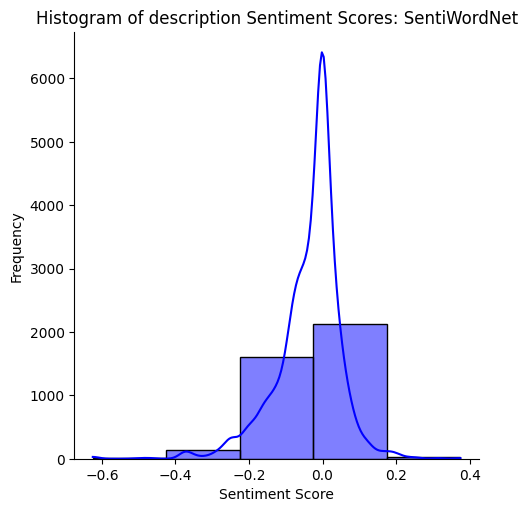

In [ ]:
sns.displot(df['description Sentiment'], color='blue', kde=True, bins=5)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of description Sentiment Scores: SentiWordNet')
plt.show()

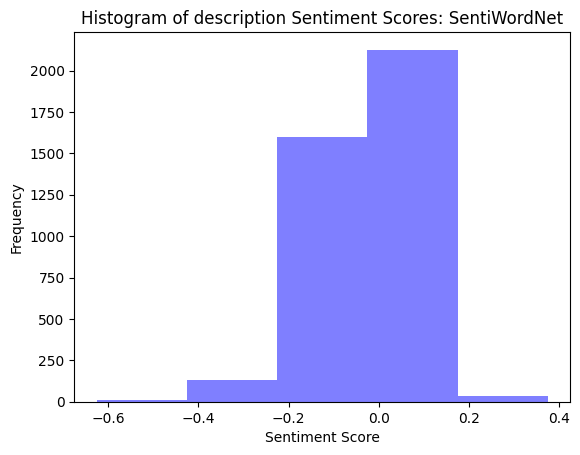

In [ ]:
plt.hist(df['description Sentiment'], bins=5, alpha=0.5, color='blue')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of description Sentiment Scores: SentiWordNet')
plt.show()

In [ ]:
new_df1 = df[df.apply(lambda x: df['medical_specialty Sentiment'] != 0.0)]

In [ ]:
new_df1=new_df1.dropna()

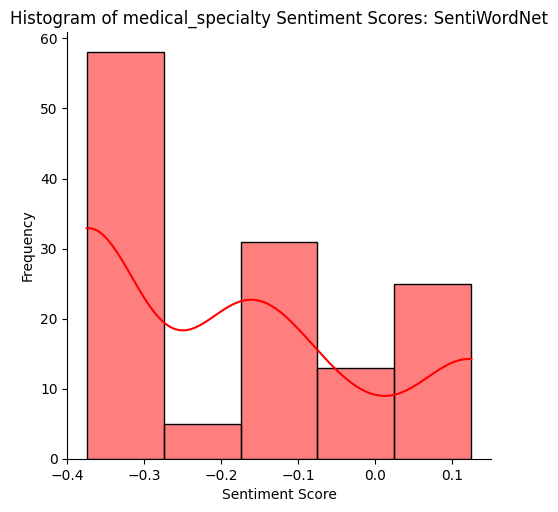

In [ ]:
sns.displot(new_df1['medical_specialty Sentiment'], bins=5, color='red', kde=True)

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of medical_specialty Sentiment Scores: SentiWordNet')
plt.show()

In [ ]:
new_df2 = df[df.apply(lambda x: df['sample_name Sentiment'] != 0.0)]
new_df2 = new_df2.dropna()

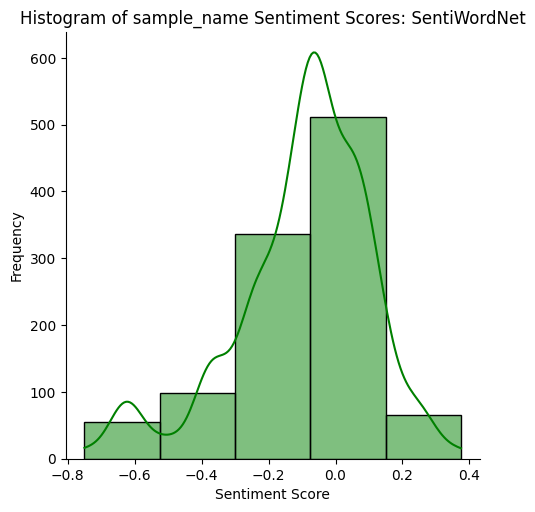

In [ ]:
sns.displot(new_df2['sample_name Sentiment'], bins=5, alpha=0.5, color='green', kde=True)

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of sample_name Sentiment Scores: SentiWordNet')
plt.show()

In [ ]:
new_df3 = df[df.apply(lambda x: df['transcription Sentiment'] != 0.0)]
new_df3 = new_df3.dropna()

In [ ]:
new_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3822 entries, 0 to 4995
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   description                  3822 non-null   object 
 1   medical_specialty            3822 non-null   object 
 2   sample_name                  3822 non-null   object 
 3   transcription                3822 non-null   object 
 4   keywords                     3822 non-null   object 
 5   description Sentiment        3822 non-null   float64
 6   medical_specialty Sentiment  3822 non-null   float64
 7   sample_name Sentiment        3822 non-null   float64
 8   transcription Sentiment      3822 non-null   float64
 9   Avg Sentiment                3822 non-null   object 
dtypes: float64(4), object(6)
memory usage: 328.5+ KB


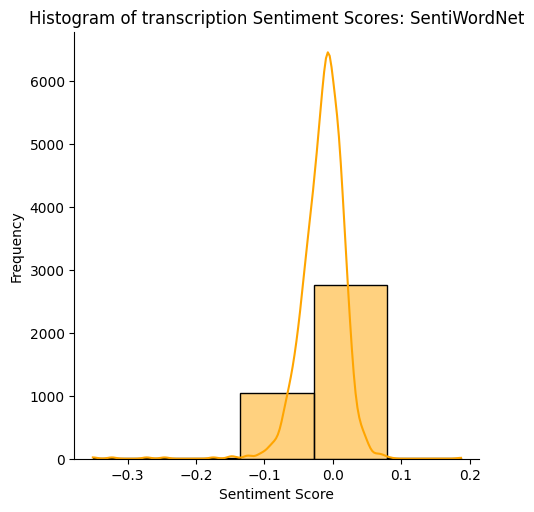

In [ ]:
sns.displot(new_df3['transcription Sentiment'], bins=5, alpha=0.5, color='orange', kde=True)

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of transcription Sentiment Scores: SentiWordNet')
plt.show()

Hugging face dataset

In [ ]:
new_df4 = data[data.apply(lambda x: data['MeSH Sentiment'] != 0.0)]
new_df4 = new_df4.dropna()

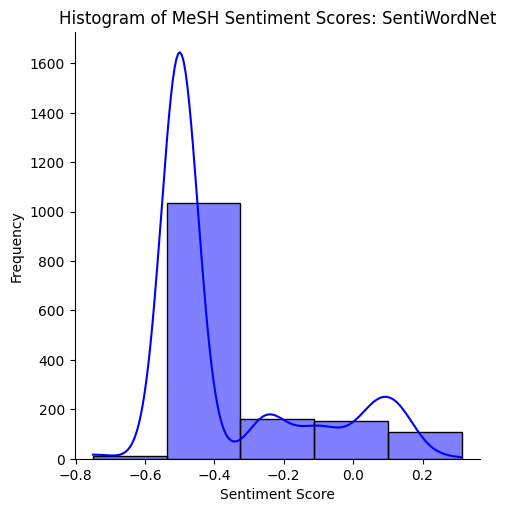

In [ ]:
sns.displot(new_df4['MeSH Sentiment'], bins=5,  color='blue', kde=True)

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of MeSH Sentiment Scores: SentiWordNet')
plt.show()

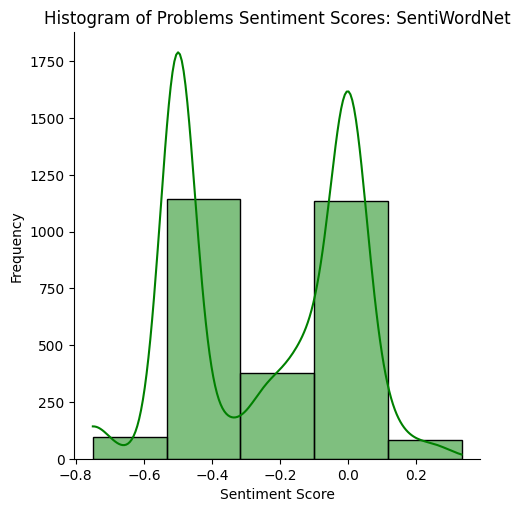

In [ ]:
sns.displot(data['Problems Sentiment'], bins=5, alpha=0.5, color='green', kde=True)

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Problems Sentiment Scores: SentiWordNet')
plt.show()

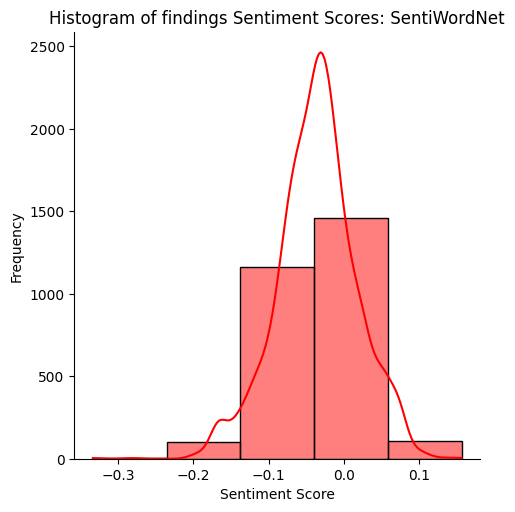

In [ ]:
sns.displot(data['findings Sentiment'], bins=5, alpha=0.5, color='red', kde=True)

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of findings Sentiment Scores: SentiWordNet')
plt.show()

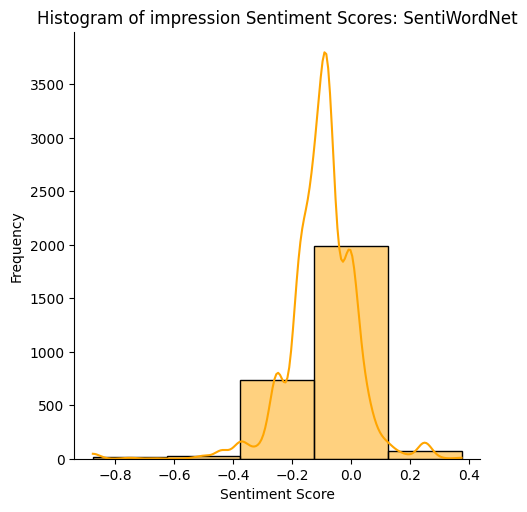

In [ ]:
sns.displot(data['impression Sentiment'], bins=5, alpha=0.5, color='orange', kde=True)

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of impression Sentiment Scores: SentiWordNet')
plt.show()

In [ ]:
data.head()

,MeSH,Problems,findings,impression,MeSH Sentiment,Problems Sentiment,findings Sentiment,impression Sentiment,Avg Sentiment
0,Atherosclerosis/aorta;Arthritis,Atherosclerosis;Arthritis,The lungs are clear. There is no pleural effus...,No acute pulmonary disease.,-0.25,-0.125,-0.008333,-0.125000,Negative
1,Bullous Emphysema/lung/apex/bilateral;Thoracic...,Bullous Emphysema;Thoracic Vertebrae,Cardiomediastinal silhouette are normal in siz...,1. No acute cardiopulmonary abnormality. 2. St...,0.00,0.000,-0.046875,-0.020833,Negative
2,Breast Implants/bilateral,Breast Implants,The heart is normal in size. The mediastinum i...,No acute disease.,0.00,0.000,-0.050000,-0.187500,Negative
3,Calcified Granuloma/lung/middle lobe,Calcified Granuloma,The cardiomediastinal silhouette is normal in ...,Negative for acute abnormality.,0.00,-0.750,-0.125000,-0.375000,Negative
4,Lung/hypoinflation;Markings/bronchovascular,Lung;Markings,There are lower lung volumes. There is central...,No acute abnormality identified.,0.00,0.000,-0.029412,-0.125000,Negative


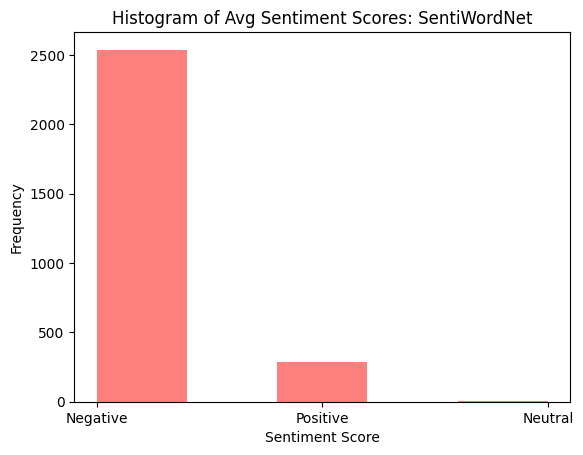

In [ ]:
plt.hist(data['Avg Sentiment'], bins=5, alpha=0.5, color='red')

plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Avg Sentiment Scores: SentiWordNet')
plt.show()

In [ ]:
df.head()

,description,medical_specialty,sample_name,transcription,keywords,description Sentiment,medical_specialty Sentiment,sample_name Sentiment,transcription Sentiment,Avg Sentiment
0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller...",-0.125,-0.0625,-0.5,-0.044014,Negative
1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh...",0.000,0.0000,0.0,-0.081461,Negative
2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart...",0.000,0.0000,0.0,-0.040984,Negative
3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple...",0.000,0.0000,0.0,-0.009868,Negative
4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo...",0.000,0.0000,0.0,-0.011364,Negative


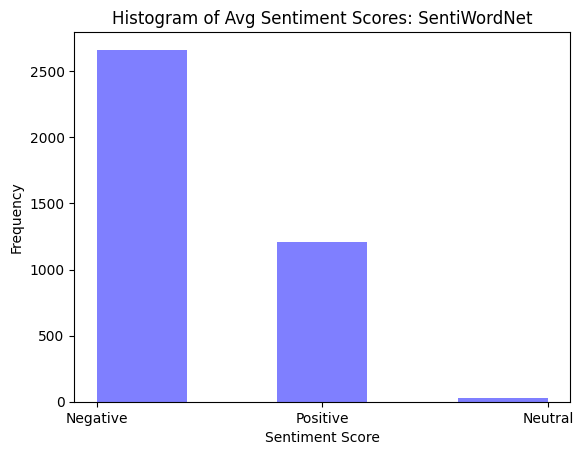

In [ ]:
plt.hist(df['Avg Sentiment'], bins=5, alpha=0.5, color='blue')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Histogram of Avg Sentiment Scores: SentiWordNet')
plt.show()